## Abstract

**In this notebook, written pilot code to extract rules and recommend rule (if the rule change) how much the outcome rate will increase from the decision tree.**

## (1) Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.datasets import load_diabetes
from sklearn.tree import (
    _tree, 
    DecisionTreeClassifier, 
    plot_tree,
)

## (2) Constants

In [2]:
SEED = 22
OUTCOME_THRESHOLD = 200
MAX_DEPTH = 5
MIN_SAMPLES_LEAF = 10

## (1) Read data

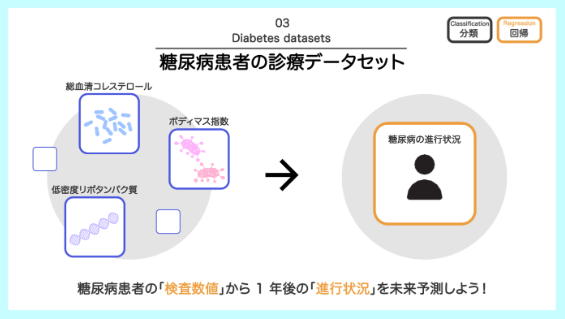

In [3]:
data_diabetes = load_diabetes()
df_diabetes = pd.concat([
    pd.DataFrame(data_diabetes["data"], columns=data_diabetes["feature_names"]),
    pd.DataFrame(data_diabetes["target"], columns=["target"]),
], axis=1)

print(df_diabetes.shape)
display(df_diabetes.sample(5))

(442, 11)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
433,-0.027310,-0.044642,-0.060097,-0.029771,0.046589,0.019980,0.122273,-0.039493,-0.051401,-0.009362,72.0
10,-0.096328,-0.044642,-0.083808,0.008101,-0.103389,-0.090561,-0.013948,-0.076395,-0.062913,-0.034215,101.0
59,0.063504,0.050680,-0.025607,0.011544,0.064477,0.048477,0.030232,-0.002592,0.038393,0.019633,170.0
390,0.009016,0.050680,0.069241,0.059744,0.017694,-0.023234,-0.047082,0.034309,0.103292,0.073480,277.0
87,0.045341,-0.044642,-0.006206,0.011544,0.063101,0.016222,0.096501,-0.039493,0.042896,-0.038357,134.0


## (2) Preprocess data

In [4]:
def add_outcome(
        df: pd.DataFrame, 
        target: str, 
        threshold: float,
    ) -> pd.DataFrame:
    """Add outcome column {0, 1} by the given target column value and given threshold.
    
    Args:
        df (pd.DataFrame): Dataframe that have features and target.
        target (str): The name of target column.
        threshold (float): Threshold to classify target column values into 2 values.
    
    Returns:
        pd.DataFrame: Dataframe that added outcome column.
    """
    df["outcome"] = 0
    df.loc[df[target] >= threshold, "outcome"] = 1
    
    return df

In [5]:
# In this dataset, `target` are continuous values
# and means a measure of disease progression one year after baseline.
# So we needs to classify two values using a given threshold.

df_diabetes = add_outcome(
    df=df_diabetes, 
    target="target",
    threshold=OUTCOME_THRESHOLD,
)

display(df_diabetes["outcome"].value_counts())

0    315
1    127
Name: outcome, dtype: int64

## (3) Train a decision tree

In [6]:
X = df_diabetes.drop(columns=["target", "outcome"])
y = df_diabetes["outcome"]

model = DecisionTreeClassifier(
    random_state=SEED,
    max_depth=MAX_DEPTH,
    min_samples_leaf=MIN_SAMPLES_LEAF,
)
model.fit(X, y)

print(model.score(X, y))

0.8619909502262444


## (4) Plot the result of the decision tree

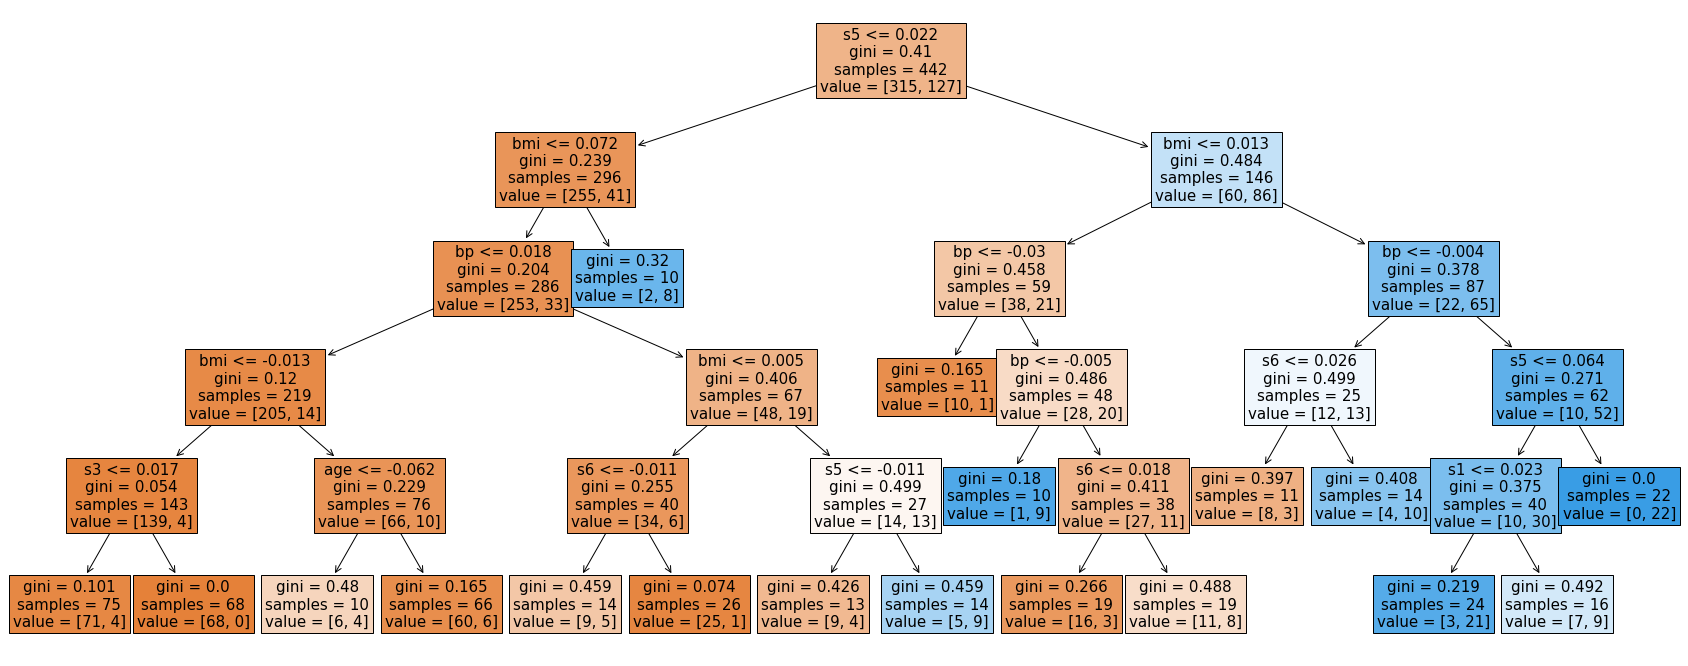

In [7]:
plt.figure(figsize=(30, 12))
plot_tree(
    model,
    feature_names=X.columns, 
    filled=True,
    fontsize=15,
    proportion=False,
)
plt.show()

## (5) Extract

In [8]:
def get_rules_and_recommends(tree, feature_names, decimals=3):
    """Get rules and recommend rule to raise outcome rate from a given trained decision tree.
    
    1. Extract rules (paths) and the number of samples and relationship of nodes.
    2. Organize info to rule / the number of samples / node pairs / node's outcome rate.
    3. Organize to the format that are the rule , the last rule, recommend rule and how much change outcome rate.
    
    Args:
        tree (DecisionTreeClassifier): Trained decision tree.
        feature_names (List[str]): The feature names used for training the decision tree.
        decimals (int): Number of decimal places to round to. Default = 3.
        
    Returns:
        pd.DataFrame: Dataframe that have rules and recommends.
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    """ 1. Extract rules (paths) and the number of samples and relationship of nodes. """
    
    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        left_node = tree_.children_left[node]
        right_node = tree_.children_right[node]
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, decimals)})"]
            recurse(left_node, p1, paths)
            p2 += [f"({name} > {np.round(threshold, decimals)})"]
            recurse(right_node, p2, paths)
        
        path += [
            (tree_.value[node].flatten()),  # the number of samples
            (node, left_node, right_node),  # current node id, left leaf node id and right leaf node id
        ]
        paths += [path]
        
    recurse(0, path, paths)
    
    """ 2. Organize info to rule / the number of samples / node pairs / node's outcome rate. """
    
    rules = []
    values = []
    node_pairs = []

    for path in paths:
        node_pairs.append(path.pop(-1))
        values.append(path.pop(-1))
        rules.append(path)
        
    details = {}
    
    for rule, value, node_pair in zip(rules, values, node_pairs):
        node = node_pair[0]
        n_sample = sum(value)
        outcome_rate = np.round(value[-1] / n_sample, decimals)
        details[node] = {
            "rule": rule,
            "sample": n_sample,
            "outcome_rate": outcome_rate,
            "left_node": node_pair[1],
            "right_node": node_pair[2],
        }
        
    """ 3. Organize to the format that are the rule , the last rule, recommend rule and how much change outcome rate. """
    
    records = []
    
    for node in details.keys():

        branch_node_detail = details[node]
        left_node = branch_node_detail["left_node"]
        right_node = branch_node_detail["right_node"]

        # Ignore the leaf node because it doesn't branch out
        if left_node == -1:
            continue

        left_node_detail = details[left_node]
        right_node_detail = details[right_node]

        left_outcome_rate = left_node_detail["outcome_rate"]
        right_outcome_rate = right_node_detail["outcome_rate"]

        left_last_rule = left_node_detail["rule"][-1]
        right_last_rule = right_node_detail["rule"][-1]

        records.append(
            [
                node,  # node
                " & ".join(branch_node_detail["rule"]),  # rule
                left_last_rule if left_outcome_rate < right_outcome_rate else right_last_rule,  # last_rule
                left_last_rule if left_outcome_rate > right_outcome_rate else right_last_rule,  # recommend_rule
                left_outcome_rate if left_outcome_rate < right_outcome_rate else right_outcome_rate,  # outcome_rate_when_reached_last_rule
                left_outcome_rate if left_outcome_rate > right_outcome_rate else right_outcome_rate,  # outcome_rate_when_reached_recommend_rule
            ]
        )
        
    df = pd.DataFrame(
        records,
        columns=[
            "node",
            "rule",
            "last_rule",
            "recommend_rule",
            "outcome_rate_when_reached_last_rule",
            "outcome_rate_when_reached_recommend_rule",
        ]
    )
    
    return df

In [9]:
df_rule_and_recommend = get_rules_and_recommends(model, X.columns)
display(df_rule_and_recommend)

,node,rule,last_rule,recommend_rule,outcome_rate_when_reached_last_rule,outcome_rate_when_reached_recommend_rule
0,4,(s5 <= 0.022) & (bmi <= 0.072) & (bp <= 0.018)...,(s3 > 0.017),(s3 <= 0.017),0.000,0.053
1,7,(s5 <= 0.022) & (bmi <= 0.072) & (bp <= 0.018)...,(age > -0.062),(age <= -0.062),0.091,0.400
2,3,(s5 <= 0.022) & (bmi <= 0.072) & (bp <= 0.018),(bmi <= -0.013),(bmi > -0.013),0.028,0.132
3,11,(s5 <= 0.022) & (bmi <= 0.072) & (bp > 0.018) ...,(s6 > -0.011),(s6 <= -0.011),0.038,0.357
4,14,(s5 <= 0.022) & (bmi <= 0.072) & (bp > 0.018) ...,(s5 <= -0.011),(s5 > -0.011),0.308,0.643
5,10,(s5 <= 0.022) & (bmi <= 0.072) & (bp > 0.018),(bmi <= 0.005),(bmi > 0.005),0.150,0.481
6,2,(s5 <= 0.022) & (bmi <= 0.072),(bp <= 0.018),(bp > 0.018),0.064,0.284
7,1,(s5 <= 0.022),(bmi <= 0.072),(bmi > 0.072),0.115,0.800
8,23,(s5 > 0.022) & (bmi <= 0.013) & (bp > -0.03) &...,(s6 <= 0.018),(s6 > 0.018),0.158,0.421
9,21,(s5 > 0.022) & (bmi <= 0.013) & (bp > -0.03),(bp > -0.005),(bp <= -0.005),0.289,0.900


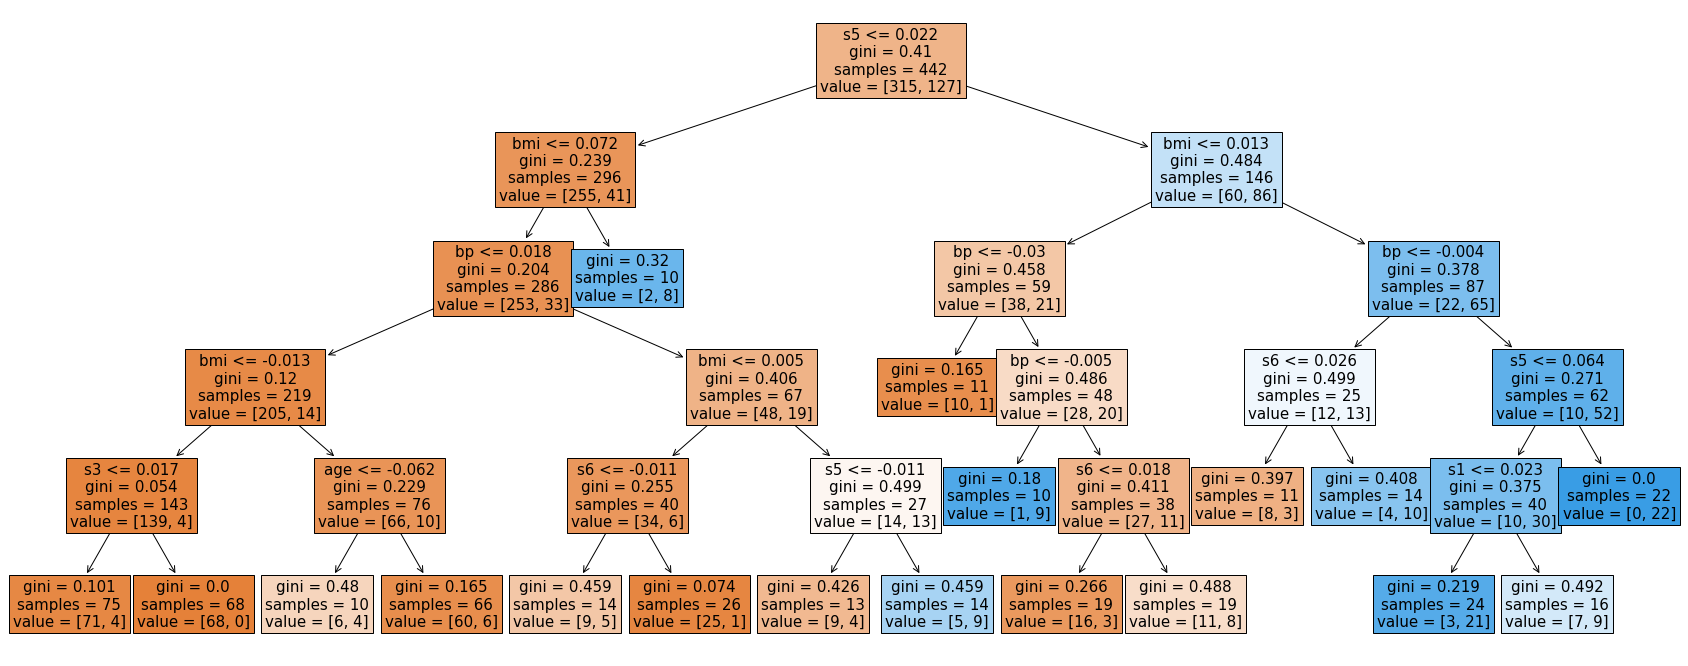

,node,rule,last_rule,recommend_rule,outcome_rate_when_reached_last_rule,outcome_rate_when_reached_recommend_rule
0,4,(s5 <= 0.022) & (bmi <= 0.072) & (bp <= 0.018)...,(s3 > 0.017),(s3 <= 0.017),0.000,0.053
1,7,(s5 <= 0.022) & (bmi <= 0.072) & (bp <= 0.018)...,(age > -0.062),(age <= -0.062),0.091,0.400
2,3,(s5 <= 0.022) & (bmi <= 0.072) & (bp <= 0.018),(bmi <= -0.013),(bmi > -0.013),0.028,0.132
3,11,(s5 <= 0.022) & (bmi <= 0.072) & (bp > 0.018) ...,(s6 > -0.011),(s6 <= -0.011),0.038,0.357
4,14,(s5 <= 0.022) & (bmi <= 0.072) & (bp > 0.018) ...,(s5 <= -0.011),(s5 > -0.011),0.308,0.643
5,10,(s5 <= 0.022) & (bmi <= 0.072) & (bp > 0.018),(bmi <= 0.005),(bmi > 0.005),0.150,0.481
6,2,(s5 <= 0.022) & (bmi <= 0.072),(bp <= 0.018),(bp > 0.018),0.064,0.284
7,1,(s5 <= 0.022),(bmi <= 0.072),(bmi > 0.072),0.115,0.800
8,23,(s5 > 0.022) & (bmi <= 0.013) & (bp > -0.03) &...,(s6 <= 0.018),(s6 > 0.018),0.158,0.421
9,21,(s5 > 0.022) & (bmi <= 0.013) & (bp > -0.03),(bp > -0.005),(bp <= -0.005),0.289,0.900


In [10]:
# For compare

plt.figure(figsize=(30, 12))
plot_tree(
    model,
    feature_names=X.columns, 
    filled=True,
    fontsize=15,
    proportion=False,
)
plt.show()

display(df_rule_and_recommend)

In [11]:
!python --version

Python 3.7.12


In [12]:
!pip freeze

absl-py==0.15.0
accelerate==0.12.0
access==1.1.8
affine==2.3.1
aiobotocore==2.4.0
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1649013150570/work
aioitertools==0.11.0
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1636093929600/work
albumentations==1.3.0
alembic==1.8.1
allennlp==2.10.0
altair==4.2.0
annoy==1.17.1
ansiwrap==0.8.4
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1652463872367/work/dist
apache-beam==2.40.0
aplus==0.11.0
appdirs @ file:///home/conda/feedstock_root/build_artifacts/appdirs_1603108395799/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1640817743617/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1649500320262/work
arrow @ file:///home/conda/feedstock_root/build_artifacts/arrow_1643313750486/work
arviz==0.12.1
asn1crypto @ file:///home/conda/feedstock_root/build_artifacts/asn1crypto_1647369152656/work
astroid==2.12.